<h1> <center>
🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐁🐁🐁🐁🐁🐁🐁🐁🐁🐁<br>
🐀 MABe Classical Classification: Baseline 💪 🐁<br>
🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐁🐁🐁🐁🐁🐁🐁🐁🐁🐁
</center>
</h1>

<p align="center"><img src="https://images.aicrowd.com/uploads/ckeditor/pictures/324/content_task1_structure.png">
</p>

In [ ]:
cd /home/blansdel/projects/mabe-task1/

In [6]:
import numpy as np
import os

from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
import keras.layers as layers
import tensorflow_addons as tfa

import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import tqdm
import gc

from matplotlib import rc

from lib.config import *

from lib.utils import animate_pose_sequence, plot_annotation_strip

# Load Data
The dataset files are python dictionaries, [this](https://colab.research.google.com/drive/1ddCX-TAdEcsUaGf09f5Glgr_G57FMK_O#scrollTo=JPsfxdl2GMcM&line=18&uniqifier=1) is a descirption of how the data is organized.



In [6]:
train = np.load('data/train.npy',allow_pickle=True).item()
test = np.load('data/test.npy',allow_pickle=True).item()
sample_submission = np.load('data/sample_submission.npy',allow_pickle=True).item()

## Dataset Specifications 💾

-   **`train.npy`** - Training set for the task, which follows the following schema:

<p align="left" style="padding: 30px">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img width="600px" src="https://i.imgur.com/GddvoT2.png">
</p>


-   **`test-release.npy`** - Test set for the task, which follows the following schema :

<p align="left" style="padding: 30px">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img width="600px" src="https://i.imgur.com/vfa8Y4V.png">
</p>

-   **`sample_submission.npy`** - Template for a sample submission which follows the following schema

```json
{
    "<sequence_id-1>" : [0, 0, 1, 2, ...],
    "<sequence_id-2>" : [0, 1, 2, 0, ...]
}
```

Each key in the dictionary here refers to the unique sequence id obtained for the sequences in the test set.
The value for each of the keys is expected to hold a list of corresponing annotations. The annotations are represented by the index of the corresponding annotation words in the vocabular provided in the test set.

## How does the data look like? 🔍

### Data overview

In [7]:
print("Dataset keys - ", train.keys())
print("Vocabulary - ", train['vocabulary'])
print("Number of train Sequences - ", len(train['sequences']))
print("Number of test Sequences - ", len(test['sequences']))

Dataset keys -  dict_keys(['vocabulary', 'sequences'])
Vocabulary -  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Number of train Sequences -  70
Number of test Sequences -  458


### Sample overview

In [8]:
sequence_names = list(train["sequences"].keys())
sequence_key = sequence_names[0]
single_sequence = train["sequences"][sequence_key]
print("Sequence name - ", sequence_key)
print("Single Sequence keys ", single_sequence.keys())
print(f"Number of Frames in {sequence_key} - ", len(single_sequence['annotations']))
print(f"Keypoints data shape of {sequence_key} - ", single_sequence['keypoints'].shape)
print(f"annotator_id of {sequence_key} - ", single_sequence['annotator_id'])

Sequence name -  1cac195d39
Single Sequence keys  dict_keys(['keypoints', 'annotator_id', 'annotations'])
Number of Frames in 1cac195d39 -  4879
Keypoints data shape of 1cac195d39 -  (4879, 2, 2, 7)
annotator_id of 1cac195d39 -  0


# Helper function for visualization 💁




Don't forget to run the cell 😉

In [4]:
rc('animation', html='jshtml')

class_to_number = {s: i for i, s in enumerate(train['vocabulary'])}
number_to_class = {i: s for i, s in enumerate(train['vocabulary'])}

NameError: name 'train' is not defined

# Visualize the mouse movements🎥

Sample visualization for plotting pose gifs.

In [10]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sequence_key,
                            keypoint_sequence, number_to_class, 
                            start_frame = 3000,
                            stop_frame = 3100,
                            annotation_sequence = annotation_sequence)

# Display the animaion on colab
ani

Processing frame  3000


NameError: name 'FRAME_HEIGHT_TOP' is not defined

<Figure size 432x288 with 0 Axes>

### Showing annotations of one of the sequeunce of the training data (Index needs to be selected for a full video)



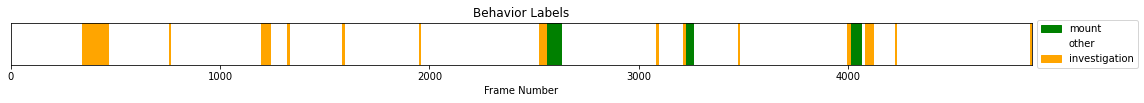

In [10]:
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence)
 
plot_annotation_strip(
    text_sequence,
    class_to_number,
    start_frame=0,
    stop_frame=len(annotation_sequence) + 1000
)

# Basic EDA 🤓
Each sequence has different amounts of each behavior, here we get the percentage of frames of each behavior in each sequence. We can use this to split the dataset for validation in a stratified way.

In [12]:
vocabulary = train['vocabulary']
def get_percentage(sequence_key):
  anno_seq = num_to_text(train['sequences'][sequence_key]['annotations'])
  counts = {k: np.mean(np.array(anno_seq) == k) for k in vocabulary}
  return counts

anno_percentages = {k: get_percentage(k) for k in train['sequences']}

anno_perc_df = pd.DataFrame(anno_percentages).T
print("Percentage of frames in every sequence for every class")
anno_perc_df

Percentage of frames in every sequence for every class


,attack,investigation,mount,other
1cac195d39,0.000000,0.077885,0.033818,0.888297
b40d39ca72,0.000000,0.625136,0.000000,0.374864
f45694e6b9,0.000000,0.375125,0.000000,0.624875
9212f26324,0.015467,0.112307,0.000000,0.872226
5490af36aa,0.438260,0.285662,0.010321,0.265757
...,...,...,...,...
bf702e3c78,0.000000,0.389482,0.000000,0.610518
0f38732507,0.000000,0.283706,0.078952,0.637342
f5c7687579,0.000000,0.288732,0.026002,0.685265
cd5fbeaa98,0.000000,0.189503,0.052890,0.757607


## Percentage Frames of all behaviors

Lets look at the class imbalance!

In [13]:
all_annotations = []
for sk in train['sequences']:
  anno = train['sequences'][sk]['annotations']
  all_annotations.extend(list(anno))
all_annotations = num_to_text(all_annotations)
classes, counts = np.unique(all_annotations, return_counts=True)
pd.DataFrame({"Behavior": classes,
              "Percentage Frames": counts/len(all_annotations)})

,Behavior,Percentage Frames
0,attack,0.027658
1,investigation,0.288777
2,mount,0.056372
3,other,0.627194


In [1]:
## Transition matrix of behaviors

In [ ]:
## 